In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, sys, os

!pwd
isLocalServer = True
print(f'isLocalServer is [{isLocalServer}]: please check whether this file is implemented in local server or not.')

if isLocalServer is True:
  sys_path_to_be_added = '/notebook/personal/ksuchoi216/FaceID-model/'
  if not sys_path_to_be_added in sys.path:
    sys.path.insert(0, sys_path_to_be_added)
    os.chdir(sys_path_to_be_added)

  print(f'System path as follows:')
  for path in sys.path:
    print(f'    {path}')
    
class Config_Manager():
  def __init__(self):
    self.cfg_path = None
    
  def set_cfg_path(self, cfg_path):
    self.cfg_path = cfg_path
  
  def get_cfg(self):
    with open(self.cfg_path) as f:
      self.cfg = json.load(f)
    return self.cfg
  
  def print(self):
    print(self.cfg)


cfgm = Config_Manager()
cfg = cfgm.set_cfg_path('./configs/config_data_preparation.json')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/notebook/personal/ksuchoi216/FaceID-model
isLocalServer is [True]: please check whether this file is implemented in local server or not.
System path as follows:
    /notebook/personal/ksuchoi216/FaceID-model/
    /notebook
    /root/.pyenv/versions/3.9.1/lib/python39.zip
    /root/.pyenv/versions/3.9.1/lib/python3.9
    /root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload
    
    /root/.pyenv/versions/python39/lib/python3.9/site-packages


# Images extracted from video

In [46]:
import cv2

cfg = cfgm.load_cfg()

data_source = cfg['data_source']
folder_for_saved_videos = cfg['folder_for_saved_videos']
folder_to_save_photos = cfg['folder_to_save_photos']
frame_count_limit = cfg['frame_count_limit']
frame_interval_for_sampling = cfg['frame_interval_for_sampling']

if not os.path.exists(folder_to_save_photos):
  os.makedirs(folder_to_save_photos)

user_names = cfg['user_names']
video_names = cfg['video_names']

for user_name, video_name in zip(user_names, video_names):
  path_for_video = folder_for_saved_videos + video_name + '.mp4'
  path_for_username_folder = folder_to_save_photos + user_name+'/'
  print(f'{path_for_video} with {path_for_username_folder}')
  
  if not os.path.exists(path_for_username_folder):
    os.makedirs(path_for_username_folder)
    
  vc = cv2.VideoCapture(path_for_video)
  success, frame = vc.read()
  
  if not success:
    print("capturing frames failed")

  count = 0
  frame_count = 0

  while success:
    success, frame = vc.read()
    if frame is not None:
      h, w, ch = frame.shape

      frame = frame[int(h*(3/8)):int(h*(8/8)), int(w*(2/8)): int(w*(6/8))]

      if frame_count == frame_count_limit:
        break

      count += 1
      if count%frame_interval_for_sampling == 0:
        path_for_save = path_for_username_folder + str(frame_count) + '.jpg'
        cv2.imwrite(path_for_save, frame)
        success, frame = vc.read()
        print(f'[{count:5}][{frame_count:4}] A image was saved at {path_for_save}')
        frame_count += 1




./data/face_video_20220908/1.mp4 with ./data/photos_from_video/jhyoo/
[   25][   0] A image was saved at ./data/photos_from_video/jhyoo/0.jpg
[   50][   1] A image was saved at ./data/photos_from_video/jhyoo/1.jpg
[   75][   2] A image was saved at ./data/photos_from_video/jhyoo/2.jpg
[  100][   3] A image was saved at ./data/photos_from_video/jhyoo/3.jpg
[  125][   4] A image was saved at ./data/photos_from_video/jhyoo/4.jpg
[  150][   5] A image was saved at ./data/photos_from_video/jhyoo/5.jpg
[  175][   6] A image was saved at ./data/photos_from_video/jhyoo/6.jpg
[  200][   7] A image was saved at ./data/photos_from_video/jhyoo/7.jpg
[  225][   8] A image was saved at ./data/photos_from_video/jhyoo/8.jpg
[  250][   9] A image was saved at ./data/photos_from_video/jhyoo/9.jpg
[  275][  10] A image was saved at ./data/photos_from_video/jhyoo/10.jpg
[  300][  11] A image was saved at ./data/photos_from_video/jhyoo/11.jpg
[  325][  12] A image was saved at ./data/photos_from_video/jhyo

KeyboardInterrupt: 

# Preprocessing


In [33]:
import torch
import torchvision
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from external_library import MTCNN, InceptionResnetV1
import warnings
warnings.filterwarnings("ignore")

print(MTCNN)

<class 'external_library.facenet_pytorch.models.mtcnn.MTCNN'>


0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi


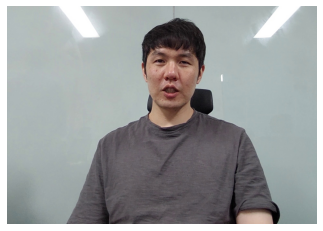

face shape: torch.Size([3, 500, 500]) / face prob: 0.9999891519546509


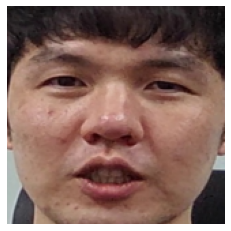

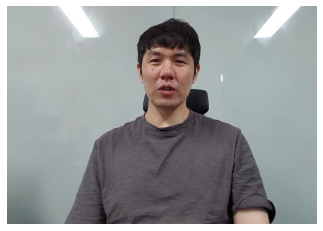

face shape: torch.Size([3, 500, 500]) / face prob: 0.9999457597732544


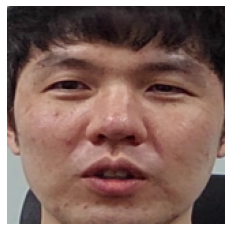

In [34]:
# initializing MTCNN and InceptionResnetV1 
image_size = 500
mtcnn = MTCNN(image_size=image_size, margin=0, keep_all=False, min_face_size=image_size*0.1) # keep_all=False
mtcnn_multi = MTCNN(image_size=image_size, margin=0, keep_all=True, min_face_size=image_size*0.1) # keep_all=True
mtcnn_show = MTCNN(select_largest=False, post_process=False)
resnet = InceptionResnetV1(pretrained='vggface2').eval()


dataset = datasets.ImageFolder(folder_to_save_photos) # photos folder path 
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

for i,c in idx_to_class.items():
    print(i,c)

def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)


#print example faces
for i, (img, idx) in enumerate(loader):
    if i < 2:
        face, prob = mtcnn(img, return_prob=True)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print(f'face shape: {face.shape} / face prob: {prob}')
    
        face_test = mtcnn_show(img)
        plt.imshow(face_test.permute(1,2,0).int().numpy())
        plt.axis('off')
        plt.show()
    else:
        break


In [42]:
from datasets import DataPreparation

cfg=cfgm.load_cfg()
dataPreparation = DataPreparation(cfg['data_preparation'])
dataPreparation.save_cropped_faces()

Starting data load...
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
data loader is created:  <torch.utils.data.dataloader.DataLoader object at 0x7f7800466970>
saved cropped face image in  ./data/photos_cropped/jhoh/1.png
saved cropped face image in  ./data/photos_cropped/jhoh/2.png
saved cropped face image in  ./data/photos_cropped/jhoh/3.png
saved cropped face image in  ./data/photos_cropped/jhoh/4.png
saved cropped face image in  ./data/photos_cropped/jhoh/5.png
saved cropped face image in  ./data/photos_cropped/jhoh/6.png
saved cropped face image in  ./data/photos_cropped/jhoh/7.png
saved cropped face image in  ./data/photos_cropped/jhoh/8.png
saved cropped face image in  ./data/photos_cropped/jhoh/9.png
saved cropped face image in  ./data/photos_cropped/jhoh/10.png
saved cropped face image in  ./data/photos_cropped/jhoh/11.png
saved cropped face image in  ./data/photos_cropped/jhoh/12.png
saved cropped face image in  ./data/photos_cropped/jhoh/13.png
saved cropped face image in  ./data/photos

In [45]:
# from PIL import Image
# import numpy as np

# def load_image(path) :
#     img = Image.open(path)
#     img.load()
#     data = np.asarray(img)
#     return data

# cfg = cfgm.load_cfg()
# data_source = cfg['data_source']
# path_folder_for_saved_images = cfg['data_preparation']['folder_for_saved_images']
# path_folder_for_saving_cropped_faces = cfg['data_preparation']['folder_for_saving_cropped_faces']

# user_names = cfg['user_names']
# theNumberOfImages = cfg['theNumberOfImages']

# for user_name in user_names:
#   data_source_path = path_folder_for_saved_images+user_name+'/'
#   # print(f'loading in {data_source_path}')
#   numpy_img_list = []
#   for i in range(theNumberOfImages):
#     file_name = str(i)+'.jpg'
#     file_path = data_source_path + file_name
#     try: 
#       numpy_img = load_image(file_path)
#       # print(f'loaded from {file_path}')
#     except:
#       print(f'Failed loading image from the file path')
#     numpy_img_list.append(numpy_img)      
    
#   img_numpy = np.array(numpy_img_list)
#   save_path = data_source + user_name + '_images.npy'
#   np.save(save_path, img_numpy, allow_pickle=True)
#   print(f'saved numpy file in {save_path}')

KeyError: 'theNumberOfImages'